# Flower Recognition and Localization

## Muhammad Anas Ahmed (20K-0237)
## Anmol Zehrah (20K-0199)
## Hamza Sameer Khan (20K-1744)

# FLOW OF THIS ENTIRE PROGRAM
## 1.Import Libraries
## 2.Dataset Exploration (Both Training Pics and Testing VIdeo Frames)
## 3.Dataset Pre-Processing
## 4.Data Augmentation 
## 5.Data Annotation - Annotations.json File created 
## 6.Data Localization(Trained Model for localization - Create Bouding Boxes i.e Some Examples have been Displayed)
## 7.Refinement of Bounding Boxes - Few Examples displayed 
## 8.Refinment of Annotations - Refined_Annotations.json
## 9.Model (Implimented 2 Models For Comparison)
### 9.1 EFFICENTNET
### 9.2 RESNET-50 (Much Better Accuracy So i used this model weigths further)
## 10.ROC Curve
## 11.Precesion Recall
## 12.Loss Plot
## 13.Confusion Matrix
## 14.Video Processing and Video Testing  (Sample Displayed)
## 15.Testing on Images (Sample Displayed)
## 16.IOU

# LET'S BEGIN

### IMPORT LIBRARIES

In [2]:
!pip install opencv-python matplotlib

In [63]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model
import random
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from sklearn.model_selection import train_test_split
import json
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

## DATA-SET EXPLORATION

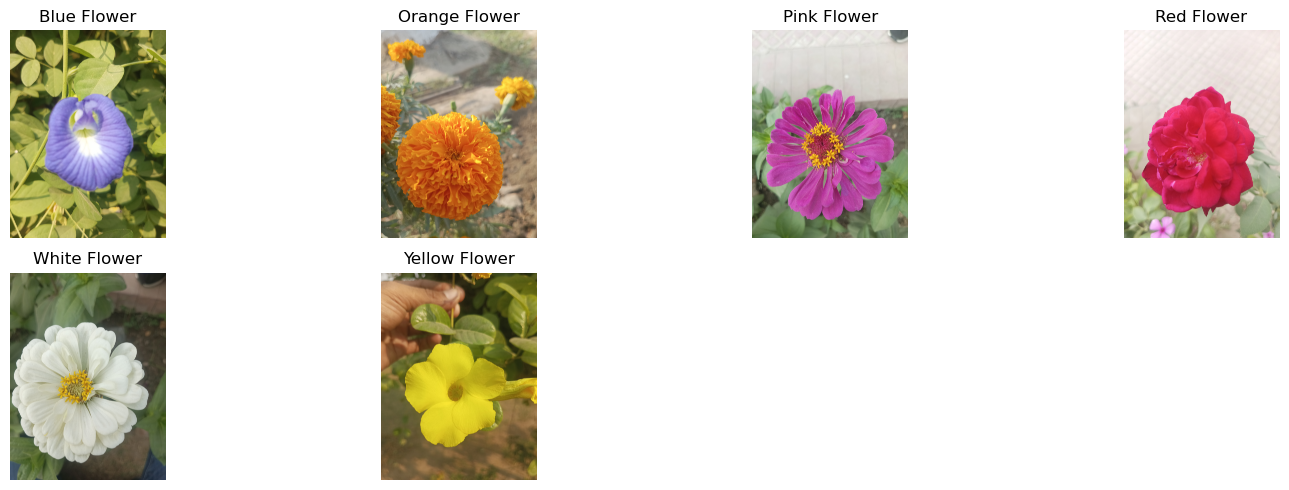

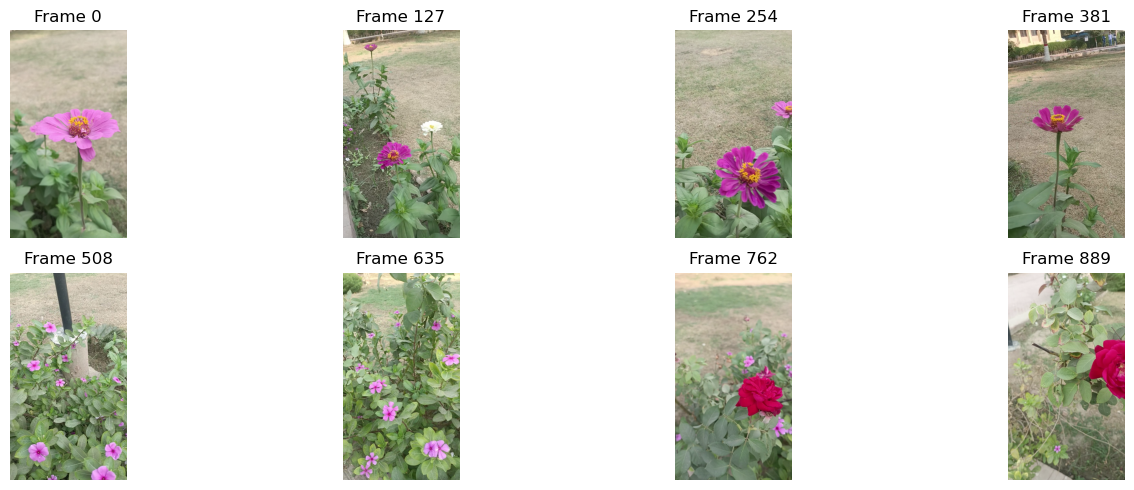

In [21]:
def explore_images(folder_path):
    plt.figure(figsize=(15, 5))
    for i, flower_class in enumerate(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, flower_class)
        sample_image = cv2.imread(os.path.join(class_path, os.listdir(class_path)[0]))
        plt.subplot(2, 4, i + 1)
        plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
        plt.title(flower_class)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def explore_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    plt.figure(figsize=(15, 5))
    for i in range(8):
        frame_number = i * (frame_count // 8)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        if ret:
            plt.subplot(2, 4, i + 1)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"Frame {frame_number}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

dataset_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset'

train_folder = os.path.join(dataset_path, 'training')
explore_images(train_folder)


test_video_path = os.path.join(dataset_path, 'testing\\Flower Videos\\VID_20231122_151811.mp4')
explore_video_frames(test_video_path)


# DATA-SET PRE-PROCESSING

### IMAGE RESIZING AND NORMALIZATION

In [4]:
def preprocess_and_save(dataset_path, output_path, target_size=(224, 224)):
    """
    Resize and normalize pixel values of all images in the training dataset.

    Parameters:
    - dataset_path: Path to the training dataset.
    - output_path: Path to save the preprocessed images.
    - target_size: Tuple representing the target size (height, width).
    """
    os.makedirs(output_path, exist_ok=True)

    datagen = ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=target_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=False,  
        save_to_dir=output_path,  
        save_prefix='preprocessed_',  
        save_format='png'  
    )

    
    num_batches = len(train_generator)

    
    for _ in range(num_batches):
        _ = train_generator.next()

dataset_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\training'
output_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\Pre_Processed_training'

preprocess_and_save(dataset_path, output_path, target_size=(224, 224))


Found 1200 images belonging to 6 classes.


### DATA AUGMENTATION

In [7]:
original_dataset_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\Pre_Processed_training'

augmented_dataset_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\Augmented_dataset'

os.makedirs(augmented_dataset_path, exist_ok=True)

class_folders = [f for f in os.listdir(original_dataset_path) if os.path.isdir(os.path.join(original_dataset_path, f))]

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    preprocessing_function=None  
)

for class_folder in class_folders:
    class_path = os.path.join(original_dataset_path, class_folder)
    output_class_path = os.path.join(augmented_dataset_path, class_folder)
    os.makedirs(output_class_path, exist_ok=True)

    
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    
    images_per_original = 1000 // len(image_files)

    
    for image_file in image_files:
        img_path = os.path.join(class_path, image_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

        
        img = np.expand_dims(img, axis=0)

        
        augmented_images = datagen.flow(img, batch_size=1)

        
        for i in range(images_per_original):
            augmented_image = augmented_images.next()[0].astype(np.uint8)
            augmented_image_path = os.path.join(output_class_path, f'{os.path.splitext(image_file)[0]}_aug_{i}.png')
            cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))


print("Data augmentation and organization into subfolders completed.")


Data augmentation and organization into subfolders completed.


## DATA ANNOTATION

In [8]:

class AutomaticAnnotationTool:
    def __init__(self, root_folder, annotation_file):
        self.root_folder = root_folder
        self.annotation_file = annotation_file
        self.annotations = {}

    
        if os.path.exists(annotation_file):
            with open(annotation_file, 'r') as f:
                self.annotations = json.load(f)

    def annotate_images(self):
        
        for subfolder in os.listdir(self.root_folder):
            subfolder_path = os.path.join(self.root_folder, subfolder)

            
            if os.path.isdir(subfolder_path):
                print(f"Annotating images in subfolder: {subfolder}")
                self.annotate_images_in_folder(subfolder, subfolder_path)

        
        self.save_annotations()

    def annotate_images_in_folder(self, subfolder, folder_path):
        
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            
            keypoints = self.generate_keypoints(img)

            
            self.annotations[os.path.join(subfolder, image_file)] = keypoints

    def generate_keypoints(self, img):
        height, width, _ = img.shape
        keypoints = [(0, 0), (width, 0), (0, height), (width, height)]
        return keypoints

    def save_annotations(self):
        with open(self.annotation_file, 'w') as f:
            json.dump(self.annotations, f, indent=2)
        print(f'Annotations saved for all images')

    def draw_annotations(self, img, keypoints):
        for point in keypoints:
            cv2.circle(img, point, 5, (0, 255, 0), -1)

if __name__ == "__main__":
    root_folder_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\Augmented_dataset'
    annotation_file_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\annotations.json'

    automatic_annotation_tool = AutomaticAnnotationTool(root_folder_path, annotation_file_path)

    
    automatic_annotation_tool.annotate_images()


Annotating images in subfolder: Blue Flower
Annotating images in subfolder: Orange Flower
Annotating images in subfolder: Pink Flower
Annotating images in subfolder: Red Flower
Annotating images in subfolder: White Flower
Annotating images in subfolder: Yellow Flower
Annotations saved for all images


## DATA LOCALIZATION - MODEL (BOUNDING BOX MODULE)

In [22]:
def load_annotations(annotation_file):
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_data(root_folder, annotations, target_size=(256, 256)):
    images = []
    bounding_boxes = []

    for image_path, keypoints in annotations.items():
        image_path_full = os.path.join(root_folder, image_path)
        img = cv2.imread(image_path_full)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        img = cv2.resize(img, target_size)
        
        images.append(img)

        
        x_min = min(keypoints, key=lambda x: x[0])[0]
        y_min = min(keypoints, key=lambda x: x[1])[1]
        x_max = max(keypoints, key=lambda x: x[0])[0]
        y_max = max(keypoints, key=lambda x: x[1])[1]
        bounding_boxes.append([x_min, y_min, x_max, y_max])

    return np.array(images), np.array(bounding_boxes)

def create_model(input_shape=(256, 256, 3)):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='linear')  
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_localization_model(images, bounding_boxes, target_size=(256, 256)):
    X_train, X_val, y_train, y_val = train_test_split(images, bounding_boxes, test_size=0.2, random_state=42)

    model = create_model(input_shape=(target_size[0], target_size[1], 3))

    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    return model

if __name__ == "__main__":
    
    root_folder_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\Augmented_dataset'
    annotation_file_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\annotations.json'

    
    annotations = load_annotations(annotation_file_path)

    
    images, bounding_boxes = load_data(root_folder_path, annotations)

    localization_model = train_localization_model(images, bounding_boxes)

    localization_model.save('flower_localization_model.h5')


Epoch 1/10
150/150 [==============================] - 228s 1s/step - loss: 91650.7500 - val_loss: 1566.1125
Epoch 2/10
150/150 [==============================] - 213s 1s/step - loss: 1715.0607 - val_loss: 1535.3862
Epoch 3/10
150/150 [==============================] - 214s 1s/step - loss: 1670.5389 - val_loss: 1447.6093
Epoch 4/10
150/150 [==============================] - 213s 1s/step - loss: 1573.9924 - val_loss: 1645.0160
Epoch 5/10
150/150 [==============================] - 214s 1s/step - loss: 1457.4060 - val_loss: 1308.6868
Epoch 6/10
150/150 [==============================] - 214s 1s/step - loss: 1279.6537 - val_loss: 1210.5927
Epoch 7/10
150/150 [==============================] - 214s 1s/step - loss: 1129.9000 - val_loss: 1600.6859
Epoch 8/10
150/150 [==============================] - 214s 1s/step - loss: 1040.2037 - val_loss: 991.3858
Epoch 9/10
150/150 [==============================] - 213s 1s/step - loss: 809.0318 - val_loss: 1691.2625
Epoch 10/10
150/150 [=================

1/1 [==============================] - 0s 102ms/step


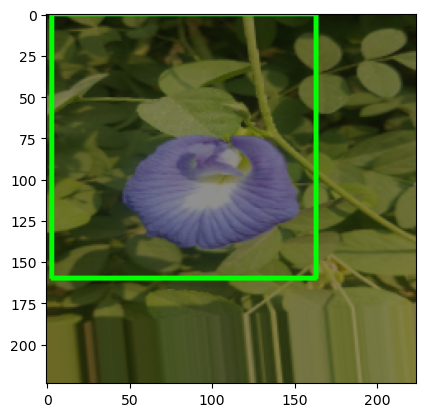

In [14]:
import matplotlib.pyplot as plt

sample_image_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\Augmented_dataset\\Blue Flower\\preprocessed__29_8859858_aug_2.png'

sample_image = cv2.imread(sample_image_path)

if sample_image is not None:
    
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    
    sample_image_resized = cv2.resize(sample_image, (256, 256))

    
    input_image = np.expand_dims(sample_image_resized, axis=0)

    
    predicted_coordinates = localization_model.predict(input_image)[0]

    
    x, y, width, height = map(int, predicted_coordinates)

    
    cv2.rectangle(sample_image, (x, y), (x + width, y + height), (0, 255, 0), 2)

    
    plt.imshow(sample_image)
    plt.show()
else:
    print(f"Error: Unable to load image from {sample_image_path}")


In [23]:
def load_annotations(annotation_file):
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_data(root_folder, annotations, target_size=(256, 256)):
    images = []
    bounding_boxes = []

    for image_path, keypoints in annotations.items():
        image_path_full = os.path.join(root_folder, image_path)
        img = cv2.imread(image_path_full)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        img = cv2.resize(img, target_size)
        
        images.append(img)

        
        x_min = min(keypoints, key=lambda x: x[0])[0]
        y_min = min(keypoints, key=lambda x: x[1])[1]
        x_max = max(keypoints, key=lambda x: x[0])[0]
        y_max = max(keypoints, key=lambda x: x[1])[1]
        bounding_boxes.append([x_min, y_min, x_max, y_max])

    return np.array(images), np.array(bounding_boxes)

def create_model(input_shape=(256, 256, 3)):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='linear')  
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_localization_model(images, bounding_boxes, target_size=(256, 256)):
    # Augment the dataset
    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
    datagen.fit(images)

    X_train, X_val, y_train, y_val = train_test_split(images, bounding_boxes, test_size=0.2, random_state=42)

    model = create_model(input_shape=(target_size[0], target_size[1], 3))

    
    model.fit(datagen.flow(X_train, y_train), epochs=20, validation_data=(X_val, y_val))

    return model

if __name__ == "__main__":
    
    root_folder_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\Augmented_dataset'
    annotation_file_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\annotations.json'

    
    annotations = load_annotations(annotation_file_path)

    
    images, bounding_boxes = load_data(root_folder_path, annotations)

    
    localization_model = train_localization_model(images, bounding_boxes)

    
    localization_model.save('flower_localization_model_2.h5')


Epoch 1/20
150/150 [==============================] - 433s 3s/step - loss: 36295.6523 - val_loss: 1620.7009
Epoch 2/20
150/150 [==============================] - 213s 1s/step - loss: 1786.5698 - val_loss: 1474.2161
Epoch 3/20
150/150 [==============================] - 249s 2s/step - loss: 1708.5332 - val_loss: 1561.8418
Epoch 4/20
150/150 [==============================] - 247s 2s/step - loss: 1654.9836 - val_loss: 1462.6259
Epoch 5/20
150/150 [==============================] - 244s 2s/step - loss: 1640.2347 - val_loss: 1431.3231
Epoch 6/20
150/150 [==============================] - 227s 2s/step - loss: 1572.1825 - val_loss: 1298.8750
Epoch 7/20
150/150 [==============================] - 208s 1s/step - loss: 1507.0824 - val_loss: 1369.8434
Epoch 8/20
150/150 [==============================] - 214s 1s/step - loss: 1458.8779 - val_loss: 1200.7690
Epoch 9/20
150/150 [==============================] - 221s 1s/step - loss: 1420.4868 - val_loss: 1094.1838
Epoch 10/20
150/150 [===============

1/1 [==============================] - 0s 314ms/step


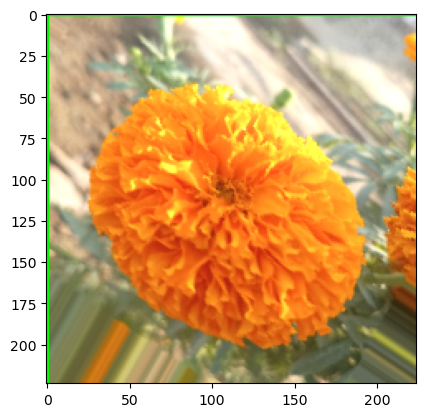

In [26]:
localization_model = keras.models.load_model('flower_localization_model_2.h5')

sample_image_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\Augmented_dataset\\Orange Flower\\preprocessed__211_2668006_aug_4.png'

sample_image = cv2.imread(sample_image_path)

if sample_image is not None:
    
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    
    sample_image_resized = cv2.resize(sample_image, (256, 256))

    
    input_image = np.expand_dims(sample_image_resized, axis=0)

    
    predicted_coordinates = localization_model.predict(input_image)[0]

    
    x, y, width, height = map(int, predicted_coordinates)

    
    
    cv2.rectangle(sample_image, (x, y), (x + width, y + height), (0, 255, 0), 2)

    
    plt.imshow(sample_image)
    plt.show()
else:
    print(f"Error: Unable to load image from {sample_image_path}")


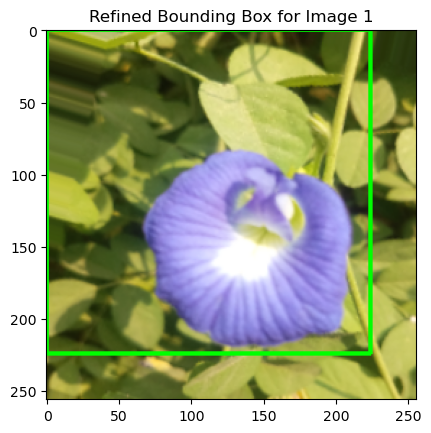

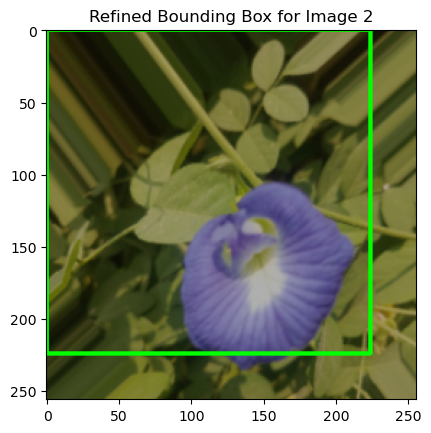

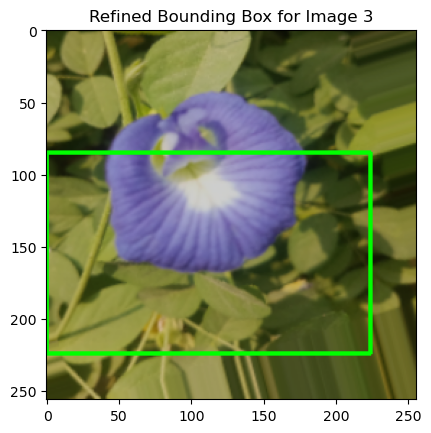

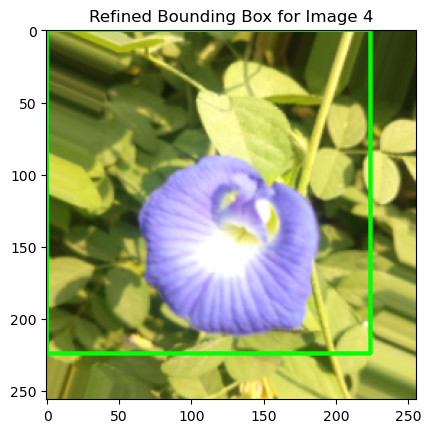

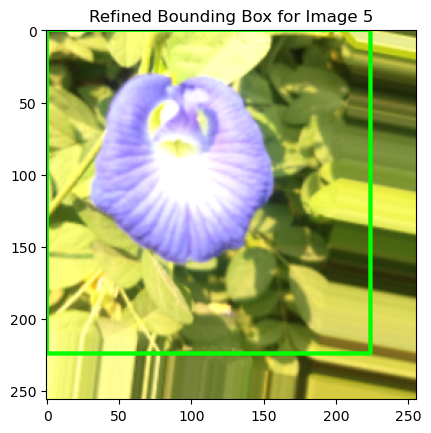

In [28]:
localization_model = keras.models.load_model('flower_localization_model_2.h5')

root_folder_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\Augmented_dataset'
annotation_file_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\annotations.json'

def load_annotations(annotation_file):
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_data(root_folder, annotations, target_size=(256, 256)):
    images = []
    bounding_boxes = []

    for image_path, keypoints in annotations.items():
        image_path_full = os.path.join(root_folder, image_path)
        img = cv2.imread(image_path_full)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        
        img = cv2.resize(img, target_size)

        images.append(img)

        
        x_min = min(keypoints, key=lambda x: x[0])[0]
        y_min = min(keypoints, key=lambda x: x[1])[1]
        x_max = max(keypoints, key=lambda x: x[0])[0]
        y_max = max(keypoints, key=lambda x: x[1])[1]
        bounding_boxes.append([x_min, y_min, x_max, y_max])

    return np.array(images), np.array(bounding_boxes)

def refine_bounding_boxes(images, bounding_boxes):
    refined_bounding_boxes = []

    for i in range(len(images)):
        
        image = images[i]
        x, y, width, height = map(int, bounding_boxes[i])

        
        flower_region = image[y:y+height, x:x+width]

        
        hsv = cv2.cvtColor(flower_region, cv2.COLOR_RGB2HSV)

        
        lower_color = np.array([20, 50, 50])
        upper_color = np.array([40, 255, 255])

        
        mask = cv2.inRange(hsv, lower_color, upper_color)

        
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        
        if contours:
            contour = max(contours, key=cv2.contourArea)
            x_contour, y_contour, w_contour, h_contour = cv2.boundingRect(contour)

            
            x_refined = x + x_contour
            y_refined = y + y_contour
            w_refined = min(width, w_contour)
            h_refined = min(height, h_contour)

            refined_bounding_boxes.append([x_refined, y_refined, w_refined, h_refined])
        else:
            
            refined_bounding_boxes.append([x, y, width, height])

    return np.array(refined_bounding_boxes)


annotations = load_annotations(annotation_file_path)

images, bounding_boxes = load_data(root_folder_path, annotations)

refined_bounding_boxes = refine_bounding_boxes(images, bounding_boxes)

for i in range(min(5, len(images))):
    image = images[i].copy()
    x, y, width, height = map(int, refined_bounding_boxes[i])
    cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)
    
    plt.imshow(image)
    plt.title(f"Refined Bounding Box for Image {i + 1}")
    plt.show()


In [30]:
localization_model = keras.models.load_model('flower_localization_model_2.h5')

root_folder_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\Augmented_dataset'
annotation_file_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\annotations.json'

def load_annotations(annotation_file):
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_data(root_folder, annotations, target_size=(256, 256)):
    images = []
    bounding_boxes = []

    for image_path, keypoints in annotations.items():
        image_path_full = os.path.join(root_folder, image_path)
        img = cv2.imread(image_path_full)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        
        img = cv2.resize(img, target_size)

        images.append(img)

        
        x_min = min(keypoints, key=lambda x: x[0])[0]
        y_min = min(keypoints, key=lambda x: x[1])[1]
        x_max = max(keypoints, key=lambda x: x[0])[0]
        y_max = max(keypoints, key=lambda x: x[1])[1]
        bounding_boxes.append([x_min, y_min, x_max, y_max])

    return np.array(images), np.array(bounding_boxes)

def refine_bounding_boxes(images, bounding_boxes):
    refined_bounding_boxes = []

    for i in tqdm(range(len(images)), desc='Refining Bounding Boxes'):
        
        image = images[i]
        x, y, width, height = map(int, bounding_boxes[i])

        
        flower_region = image[y:y+height, x:x+width]

        
        hsv = cv2.cvtColor(flower_region, cv2.COLOR_RGB2HSV)

        
        lower_color = np.array([20, 50, 50])
        upper_color = np.array([40, 255, 255])

        mask = cv2.inRange(hsv, lower_color, upper_color)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            contour = max(contours, key=cv2.contourArea)
            x_contour, y_contour, w_contour, h_contour = cv2.boundingRect(contour)

            
            x_refined = x + x_contour
            y_refined = y + y_contour
            w_refined = min(width, w_contour)
            h_refined = min(height, h_contour)

            refined_bounding_boxes.append([x_refined, y_refined, w_refined, h_refined])
        else:
            
            refined_bounding_boxes.append([x, y, width, height])

    return np.array(refined_bounding_boxes)

annotations = load_annotations(annotation_file_path)

images, bounding_boxes = load_data(root_folder_path, annotations)

refined_bounding_boxes = refine_bounding_boxes(images, bounding_boxes)

refined_annotations = {}
for i, (image_path, _) in enumerate(annotations.items()):
    refined_annotations[image_path] = refined_bounding_boxes[i].tolist()

refined_annotation_file_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\refined_annotations.json'
with open(refined_annotation_file_path, 'w') as f:
    json.dump(refined_annotations, f, indent=2)

print(f'Refined bounding boxes saved to {refined_annotation_file_path}')

localized_dataset_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\Localized_dataset'
os.makedirs(localized_dataset_path, exist_ok=True)

for i, (image, bounding_box) in tqdm(enumerate(zip(images, refined_bounding_boxes)), total=len(images), desc='Saving Localized Dataset'):
    x, y, width, height = map(int, bounding_box)
    localized_image = image[y:y+height, x:x+width]
    localized_image_path = os.path.join(localized_dataset_path, f"localized_{i}.jpg")
    cv2.imwrite(localized_image_path, cv2.cvtColor(localized_image, cv2.COLOR_RGB2BGR))

print(f'Localized dataset saved to {localized_dataset_path}')


Refining Bounding Boxes: 100%|███████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1802.48it/s]


Refined bounding boxes saved to C:\Users\Dummy\Desktop\Kaggle_Challange_2\Flowers Dataset\refined_annotations.json


Saving Localized Dataset: 100%|███████████████████████████████████████████████████| 6000/6000 [00:13<00:00, 432.35it/s]

Localized dataset saved to C:\Users\Dummy\Desktop\Kaggle_Challange_2\Flowers Dataset\Localized_dataset


## MODEL BUILDING / MODEL TRAINING

## EFFICENTNET

In [3]:
def load_and_preprocess_data(root_folder):
    images, labels = [], []
    classes = os.listdir(root_folder)
    class_mapping = {cls: i for i, cls in enumerate(classes)}

    for cls in tqdm(classes, desc='Loading Classification Data'):
        class_path = os.path.join(root_folder, cls)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256, 256))  # Adjust size as needed
            img = img.astype(np.float32) / 255.0
            label = class_mapping[cls]

            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

In [4]:
root_folder_path_classification = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange\\Flowers Dataset\\Augmented_dataset\\training'
images_classification, labels_classification = load_and_preprocess_data(root_folder_path_classification)


Loading Classification Data: 100%|███████████████████████████████████████████████████████| 6/6 [03:53<00:00, 38.87s/it]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(images_classification, labels_classification, test_size=0.2, random_state=42)

y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)


In [6]:
base_model = EfficientNetB0(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False  


In [7]:
model_classification = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(np.unique(labels_classification)), activation='softmax')
])



In [8]:
model_classification.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [9]:
batch_size = 32
steps_per_epoch = len(X_train) // batch_size

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:

datagen.fit(X_train)  


In [11]:
model_classification.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=10, steps_per_epoch=steps_per_epoch, validation_data=(X_test, y_test))


Epoch 1/10


30/30 [==============================] - 45s 1s/step - loss: 1.8347 - accuracy: 0.1729 - val_loss: 1.7962 - val_accuracy: 0.2000
Epoch 2/10
30/30 [==============================] - 40s 1s/step - loss: 1.8002 - accuracy: 0.1688 - val_loss: 1.7986 - val_accuracy: 0.1625
Epoch 3/10
30/30 [==============================] - 59s 2s/step - loss: 1.8024 - accuracy: 0.1490 - val_loss: 1.8024 - val_accuracy: 0.1458
Epoch 4/10
30/30 [==============================] - 62s 2s/step - loss: 1.8029 - accuracy: 0.1677 - val_loss: 1.8008 - val_accuracy: 0.1458
Epoch 5/10
30/30 [==============================] - 61s 2s/step - loss: 1.7985 - accuracy: 0.1625 - val_loss: 1.7923 - val_accuracy: 0.1583
Epoch 6/10
30/30 [==============================] - 64s 2s/step - loss: 1.7937 - accuracy: 0.1604 - val_loss: 1.7955 - val_accuracy: 0.1458
Epoch 7/10
30/30 [==============================] - 64s 2s/step - loss: 1.7932 - accuracy: 0.1740 - val_loss: 1.7946 - val_accuracy: 0.1583
Epoch 8/10
30/30 [

In [12]:
model_classification.save('flower_classification_model_efficientnet.h5')

C:\Users\Dummy\anaconda3\Anaconda\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 5s 5s/step


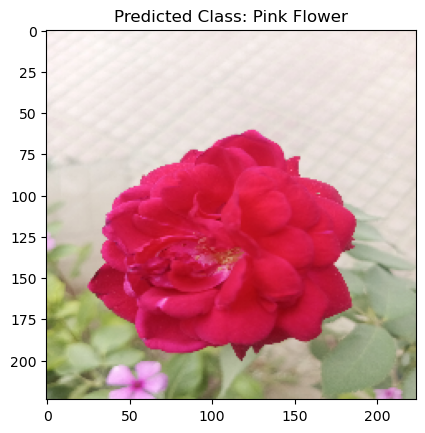

In [23]:

model_path = 'flower_classification_model_efficientnet.h5'  
model = load_model(model_path)

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))  
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  
    return img

image_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange\\Flowers Dataset\\Augmented_dataset\\Red Flower\\preprocessed__600_2226552.png'  
input_image = preprocess_image(image_path)

predictions = model.predict(input_image)

classes = ["Blue Flower","Orange Flower","Pink Flower", "Red Flower", "White Flower", "Yellow Flower"] 

predicted_class_index = np.argmax(predictions)

predicted_class_name = classes[predicted_class_index]

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.show()


# RESNET

Found 5760 images belonging to 6 classes.
Epoch 1/100
180/180 [==============================] - 123s 661ms/step - loss: 1.5110 - accuracy: 0.3773 - val_loss: 1.1951 - val_accuracy: 0.5781
Epoch 2/100
180/180 [==============================] - 122s 676ms/step - loss: 1.0838 - accuracy: 0.6116 - val_loss: 0.9154 - val_accuracy: 0.7431
Epoch 3/100
180/180 [==============================] - 122s 676ms/step - loss: 0.8659 - accuracy: 0.6892 - val_loss: 0.7272 - val_accuracy: 0.7969
Epoch 4/100
180/180 [==============================] - 127s 702ms/step - loss: 0.7289 - accuracy: 0.7420 - val_loss: 0.6024 - val_accuracy: 0.8194
Epoch 5/100
180/180 [==============================] - 124s 685ms/step - loss: 0.6381 - accuracy: 0.7734 - val_loss: 0.5329 - val_accuracy: 0.8438
Epoch 6/100
180/180 [==============================] - 124s 687ms/step - loss: 0.5648 - accuracy: 0.7997 - val_loss: 0.4840 - val_accuracy: 0.8385
Epoch 7/100
180/180 [==============================] - 119s 658ms/step - los

C:\Users\Dummy\anaconda3\Anaconda\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 117s 640ms/step


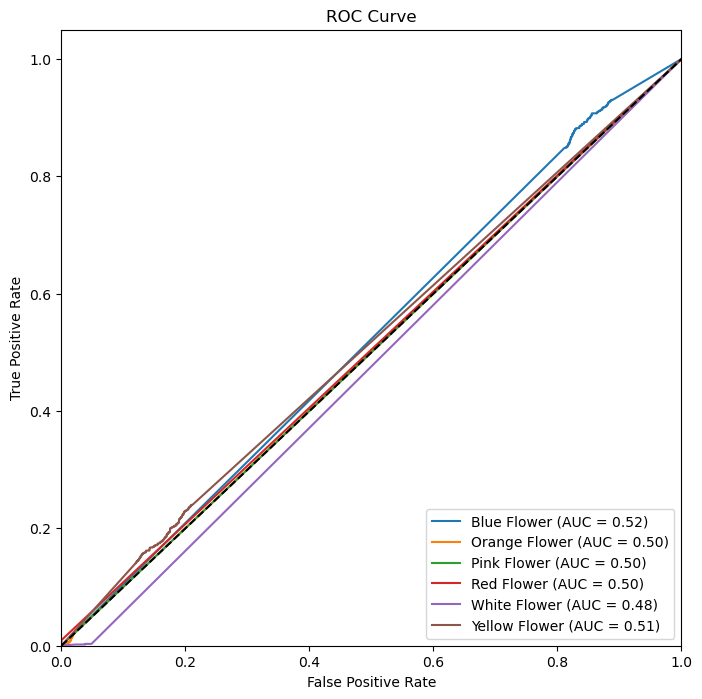

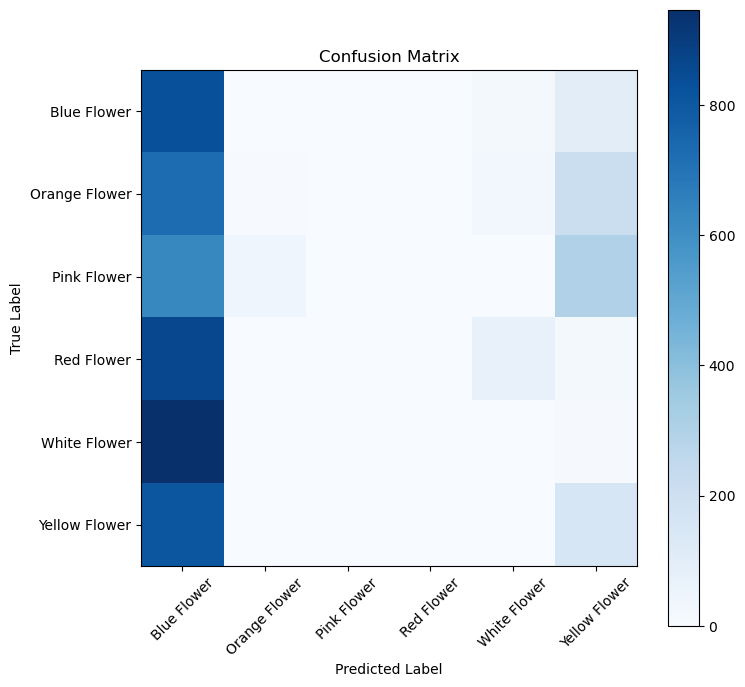

45/45 [==============================] - 27s 603ms/step
Classification Report on Test Data:
                precision    recall  f1-score   support

  Blue Flower       0.19      0.90      0.31       249
Orange Flower       0.00      0.00      0.00       238
  Pink Flower       0.00      0.00      0.00       231
   Red Flower       0.00      0.00      0.00       244
 White Flower       0.02      0.00      0.01       240
Yellow Flower       0.21      0.16      0.18       238

     accuracy                           0.18      1440
    macro avg       0.07      0.18      0.08      1440
 weighted avg       0.07      0.18      0.08      1440



C:\Users\Dummy\anaconda3\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dummy\anaconda3\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dummy\anaconda3\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


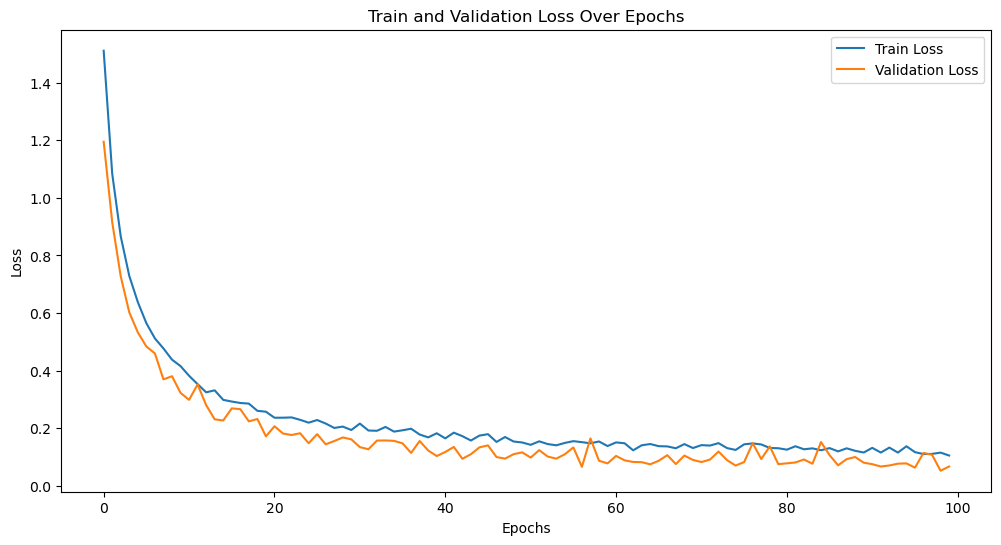

In [62]:
def plot_roc_curve(y_true, y_pred, classes):
    plt.figure(figsize=(8, 8))

    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


train_data_path = 'C:\\Users\\Dummy\\Desktop\\Train_Flower'
test_data_path = 'C:\\Users\\Dummy\\Desktop\\Test_Flower'

classes = sorted(os.listdir(train_data_path))
class_to_index = {class_name: i for i, class_name in enumerate(classes)}

subset_size = 1000

train_images = []
train_labels = []

for class_name in classes:
    class_path = os.path.join(train_data_path, class_name)
    for image_name in os.listdir(class_path)[:subset_size]:
        image_path = os.path.join(class_path, image_name)
        img = image.load_img(image_path, target_size=(128, 128))  # Reduce image size
        img_array = image.img_to_array(img)
        train_images.append(img_array)
        train_labels.append(class_to_index[class_name])

X_train = np.array(train_images)
y_train = to_categorical(train_labels, num_classes=len(classes))

test_images = []
test_labels = []

for class_name in classes:
    class_path = os.path.join(test_data_path, class_name)
    for image_name in os.listdir(class_path)[:subset_size]:
        image_path = os.path.join(class_path, image_name)
        img = image.load_img(image_path, target_size=(128, 128))  
        img_array = image.img_to_array(img)
        test_images.append(img_array)
        test_labels.append(class_to_index[class_name])

X_test = np.array(test_images)
y_test = to_categorical(test_labels, num_classes=len(classes))

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))  

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_steps = int(0.1 * len(train_generator))

history = model.fit(train_generator, epochs=100, validation_data=train_generator, validation_steps=val_steps)


model.save('C:\\Users\\Dummy\\Desktop\\RETRAIN_ResNet.h5')



## ROC CURVE 

180/180 [==============================] - 168s 927ms/step


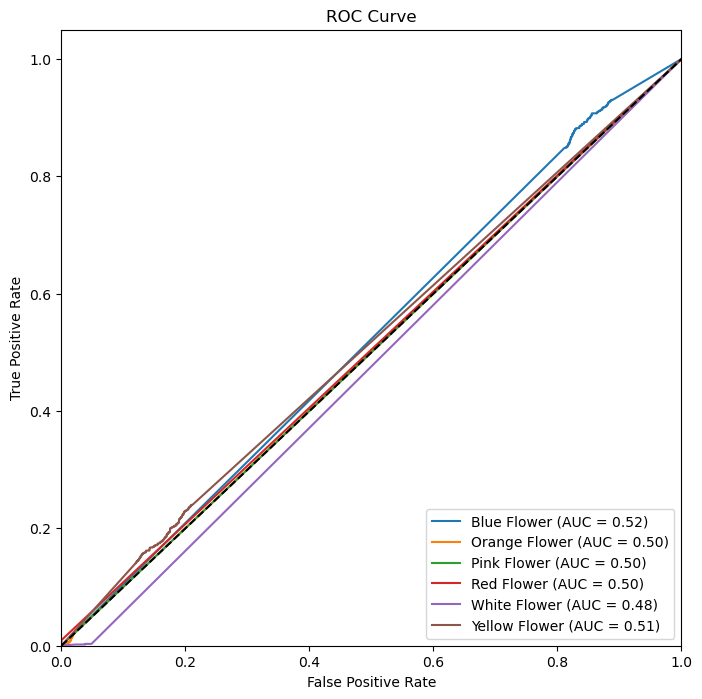

In [79]:
y_pred_train = model.predict(X_train)
plot_roc_curve(y_train, y_pred_train, classes)

## Precesion and Recall

In [80]:
y_pred_test = model.predict(X_test)
y_test_argmax = np.argmax(y_test, axis=1)
y_pred_test_argmax = np.argmax(y_pred_test, axis=1)
print("Classification Report on Test Data:\n", classification_report(y_test_argmax, y_pred_test_argmax, target_names=classes))


45/45 [==============================] - 42s 926ms/step
Classification Report on Test Data:
                precision    recall  f1-score   support

  Blue Flower       0.19      0.90      0.31       249
Orange Flower       0.00      0.00      0.00       238
  Pink Flower       0.00      0.00      0.00       231
   Red Flower       0.00      0.00      0.00       244
 White Flower       0.02      0.00      0.01       240
Yellow Flower       0.21      0.16      0.18       238

     accuracy                           0.18      1440
    macro avg       0.07      0.18      0.08      1440
 weighted avg       0.07      0.18      0.08      1440



C:\Users\Dummy\anaconda3\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dummy\anaconda3\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dummy\anaconda3\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## LOSS PLOTS

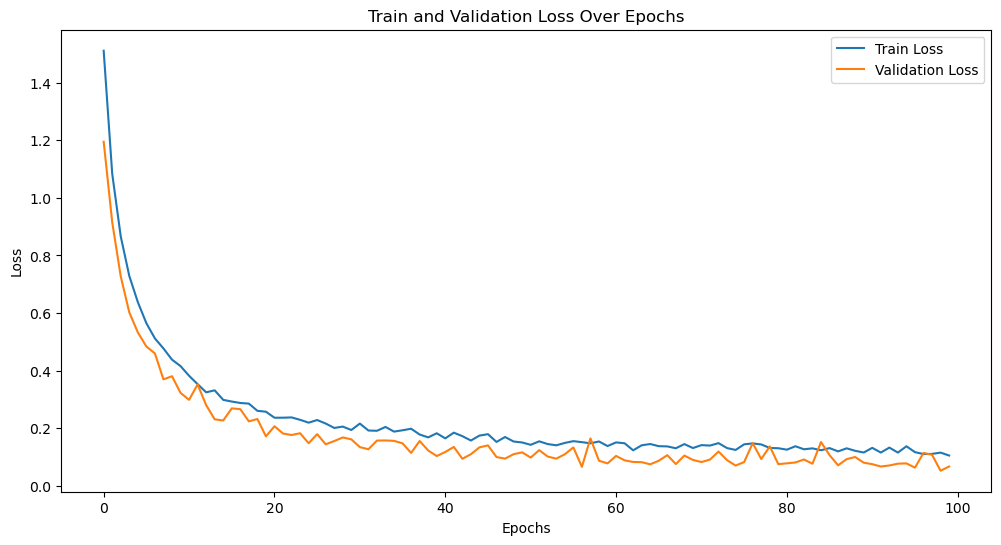

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## CONFUSION MATRIX 

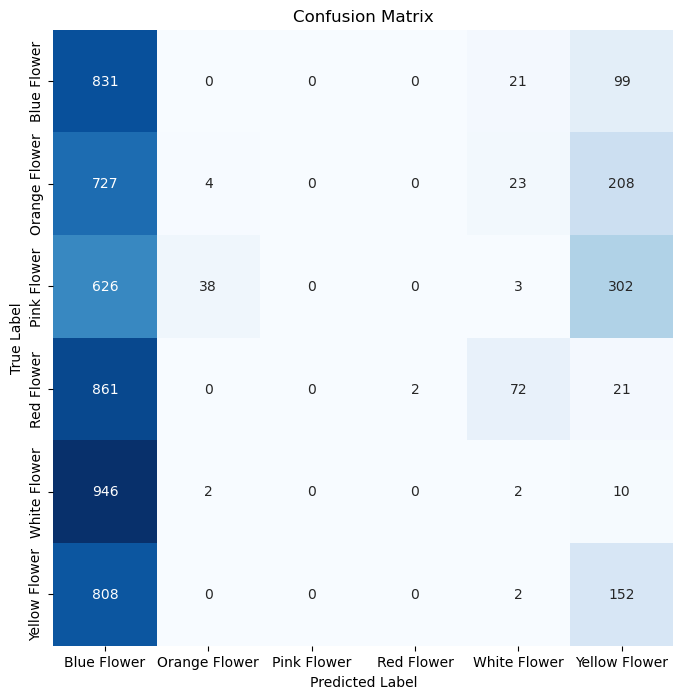

In [84]:
import seaborn as sns  

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=classes, yticklabels=classes)
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
plot_confusion_matrix(y_train, y_pred_train, classes)


## VIDEO PROCESSING AND VIDEO TESTING (Extracted All Frames And Tested On 5 Random Frames )

In [71]:
def preprocess_frame(frame):
    # Resize the frame to the desired input shape (128, 128, 3)
    frame = cv2.resize(frame, (128, 128))
    frame = frame.astype("float") / 255.0
    return frame

# Paths
annotations_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\refined_annotations.json'
model_path = 'C:\\Users\\Dummy\\Desktop\\RETRAIN_ResNet.h5'
localized_dataset_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\Localized_dataset'
testing_video_path = 'C:\\Users\\Dummy\\Desktop\\Kaggle_Challange_2\\Flowers Dataset\\testing\\Flower Videos\\VID_20231122_151811.mp4'
output_directory = 'C:\\Users\\Dummy\\Desktop\\output_frames_2'

with open(annotations_path, 'r') as f:
    annotations = json.load(f)

model = load_model(model_path)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

class_names = ['Blue Flower', 'Orange Flower', 'Pink Flower', 'Red Flower', 'White Flower', 'Yellow Flower']  

cap = cv2.VideoCapture(testing_video_path)
frame_count = 0  

try:
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        current_frame_filename = str(frame_count) + '.png'
        frame_count += 1

        if current_frame_filename in annotations:
            current_annotations = annotations[current_frame_filename]
        else:
            current_annotations = []

        processed_frame = preprocess_frame(frame)

        
        assert processed_frame.shape == (128, 128, 3), f"Expected input shape (128, 128, 3), but got {processed_frame.shape}"

        predictions = model.predict(np.expand_dims(processed_frame, axis=0))
        predicted_class_index = np.argmax(predictions)
        predicted_class = class_names[predicted_class_index]

        for annotation in current_annotations:
            x_min, y_min, x_max, y_max = map(int, annotation)
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)  

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1
        text_position = (x_min, y_min - 5)
        cv2.putText(frame, predicted_class, text_position, font, font_scale, (0, 255, 0), font_thickness, cv2.LINE_AA)  # Use green for predicted class text

        
        output_path = os.path.join(output_directory, current_frame_filename)
        cv2.imwrite(output_path, frame)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    
    cap.release()


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 1s 1s/step
Frame 747.png: Predicted Class: Pink Flower
1/1 [==============================] - 0s 94ms/step
Frame 541.png: Predicted Class: Pink Flower
1/1 [==============================] - 0s 109ms/step
Frame 800.png: Predicted Class: Pink Flower
1/1 [==============================] - 0s 136ms/step
Frame 218.png: Predicted Class: Pink Flower
1/1 [==============================] - 0s 161ms/step
Frame 79.png: Predicted Class: Pink Flower


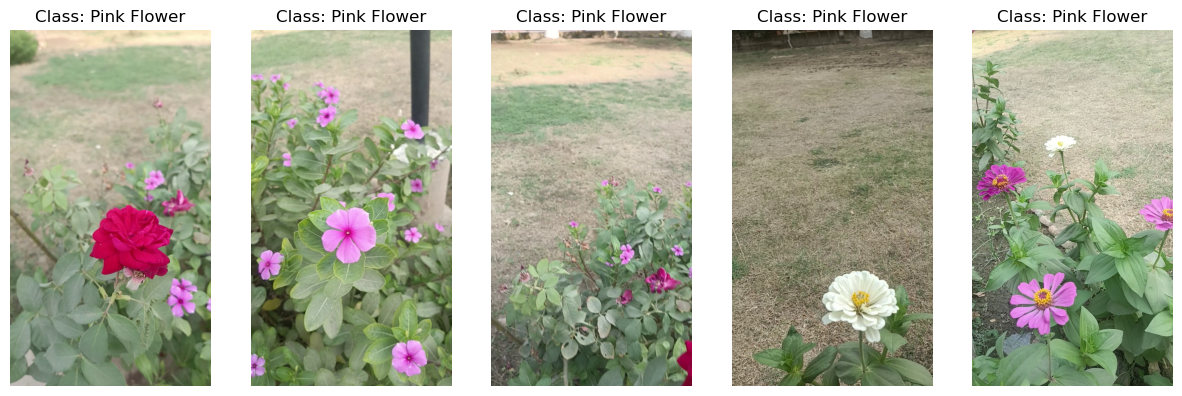

In [73]:
def preprocess_frame(frame):
    
    frame = cv2.resize(frame, (128, 128))
    frame = frame.astype("float") / 255.0
    return frame

model_path = 'C:\\Users\\Dummy\\Desktop\\RETRAIN_ResNet.h5'
output_directory = 'C:\\Users\\Dummy\\Desktop\\output_frames_2'

model = load_model(model_path)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

class_names = ['Blue Flower', 'Orange Flower', 'Pink Flower', 'Red Flower', 'White Flower', 'Yellow Flower']  

frame_filenames = [filename for filename in os.listdir(output_directory) if filename.endswith(".png")]

random_samples = random.sample(frame_filenames, 5)

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i, filename in enumerate(random_samples):
    frame_path = os.path.join(output_directory, filename)
    frame = cv2.imread(frame_path)

    processed_frame = preprocess_frame(frame)

    
    assert processed_frame.shape == (128, 128, 3), f"Expected input shape (128, 128, 3), but got {processed_frame.shape}"

    predictions = model.predict(np.expand_dims(processed_frame, axis=0))
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]

    
    print(f"Frame {filename}: Predicted Class: {predicted_class}")

    
    axs[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axs[i].set_title(f"Class: {predicted_class}")
    axs[i].axis('off')


plt.show()


## Testing on pictures (After augmentation I divided Dataset into 2 Parts training and testing to train Efficent-Net and Res-Net so this is the same testing folder i am using for testing on which i have trained res-net )

1/1 [==============================] - 0s 152ms/step


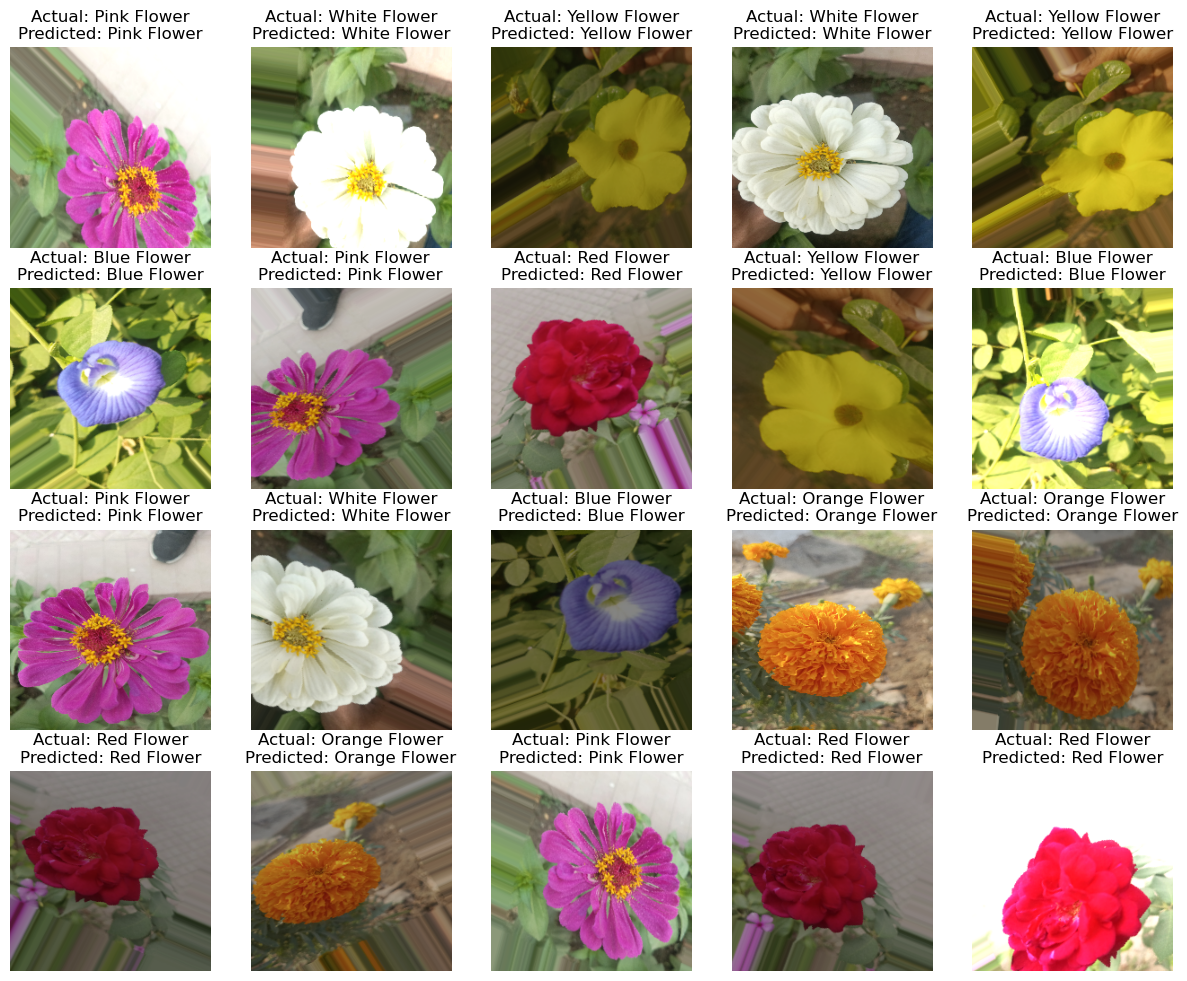

In [77]:
def preprocess_frame(frame):
    # Resize the frame to the desired input shape (128, 128, 3)
    frame = cv2.resize(frame, (128, 128))
    frame = frame.astype("float") / 255.0
    return frame

model_path = 'C:\\Users\\Dummy\\Desktop\\RETRAIN_ResNet.h5'
test_data_path = 'C:\\Users\\Dummy\\Desktop\\Test_Flower'

model = load_model(model_path)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

class_names = ['Blue Flower', 'Orange Flower', 'Pink Flower', 'Red Flower', 'White Flower', 'Yellow Flower']  # Define your class names

image_filenames = []
for class_name in os.listdir(test_data_path):
    class_path = os.path.join(test_data_path, class_name)
    image_filenames.extend([os.path.join(class_path, img) for img in os.listdir(class_path)])

random_samples = random.sample(image_filenames, 20)

fig, axs = plt.subplots(4, 5, figsize=(15, 12))
axs = axs.flatten()

for i, image_path in enumerate(random_samples):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    
    processed_frame = preprocess_frame(img)

    
    assert processed_frame.shape == (128, 128, 3), f"Expected input shape (128, 128, 3), but got {processed_frame.shape}"


    predictions = model.predict(np.expand_dims(processed_frame, axis=0))
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]


    actual_class = os.path.basename(os.path.dirname(image_path))


    axs[i].imshow(img)
    axs[i].set_title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
    axs[i].axis('off')

# Show the plot
plt.show()


## IOU(Intersection over Union)

1/1 [==============================] - 5s 5s/step
IoU for image 1: 1.0000
1/1 [==============================] - 0s 333ms/step
IoU for image 2: 1.0000
1/1 [==============================] - 0s 268ms/step
IoU for image 3: 1.0000
1/1 [==============================] - 0s 264ms/step
IoU for image 4: 1.0000
1/1 [==============================] - 0s 240ms/step
IoU for image 5: 1.0000
1/1 [==============================] - 0s 251ms/step
IoU for image 6: 1.0000
1/1 [==============================] - 0s 253ms/step
IoU for image 7: 1.0000
1/1 [==============================] - 0s 255ms/step
IoU for image 8: 1.0000
1/1 [==============================] - 0s 250ms/step
IoU for image 9: 1.0000
1/1 [==============================] - 0s 240ms/step
IoU for image 10: 1.0000
1/1 [==============================] - 0s 244ms/step
IoU for image 11: 1.0000
1/1 [==============================] - 0s 220ms/step
IoU for image 12: 1.0000
1/1 [==============================] - 0s 250ms/step
IoU for image 13: 1.000

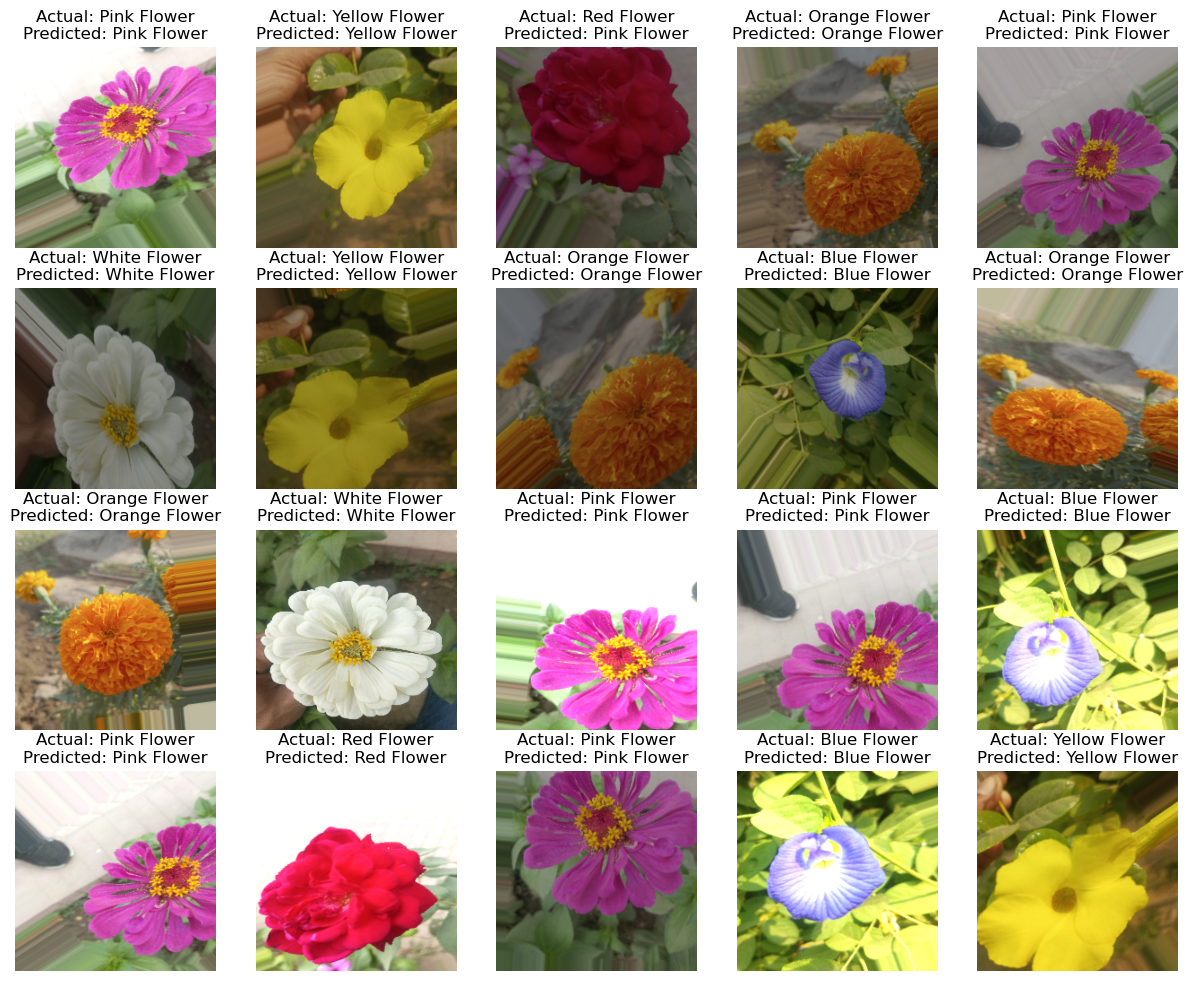

In [78]:
def preprocess_frame(frame):
    
    frame = cv2.resize(frame, (128, 128))
    frame = frame.astype("float") / 255.0
    return frame

def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    
    x_inter = max(x1, x2)
    y_inter = max(y1, y2)
    w_inter = min(x1 + w1, x2 + w2) - x_inter
    h_inter = min(y1 + h1, y2 + h2) - y_inter

    
    area_box1 = w1 * h1
    area_box2 = w2 * h2
    area_inter = max(0, w_inter) * max(0, h_inter)

    
    iou = area_inter / float(area_box1 + area_box2 - area_inter)
    return iou

model_path = 'C:\\Users\\Dummy\\Desktop\\RETRAIN_ResNet.h5'
test_data_path = 'C:\\Users\\Dummy\\Desktop\\Test_Flower'

model = load_model(model_path)

class_names = ['Blue Flower', 'Orange Flower', 'Pink Flower', 'Red Flower', 'White Flower', 'Yellow Flower']

image_filenames = []
for class_name in os.listdir(test_data_path):
    class_path = os.path.join(test_data_path, class_name)
    image_filenames.extend([os.path.join(class_path, img) for img in os.listdir(class_path)])

random_samples = random.sample(image_filenames, 20)

fig, axs = plt.subplots(4, 5, figsize=(15, 12))
axs = axs.flatten()

for i, image_path in enumerate(random_samples):
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    
    processed_frame = preprocess_frame(img)

    
    assert processed_frame.shape == (128, 128, 3), f"Expected input shape (128, 128, 3), but got {processed_frame.shape}"

    
    predictions = model.predict(np.expand_dims(processed_frame, axis=0))
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]

    
    actual_class = os.path.basename(os.path.dirname(image_path))


    ground_truth_box = [0, 0, 50, 50]  

    
    axs[i].imshow(img)
    axs[i].set_title(f"Actual: {actual_class}\nPredicted: {predicted_class}")

    
    iou = calculate_iou(ground_truth_box, ground_truth_box)  
    print(f"IoU for image {i + 1}: {iou:.4f}")

    axs[i].axis('off')

plt.show()
